# Data simulation

This notebook demonstrates synthetic data creation with TomoPy to create sinograms with various types of defects:
1. Poisson Noise
2. Rings
3. Zingers
4. Illumination drift

In [1]:
import tomopy
import matplotlib.pyplot as plt
import numpy as np

## Load a built-in object

TomoPy comes with 9 images which can be used a phantoms: baboon, barbara, cameraman, checkerboard, lena, peppers, phantom, shepp2d, shepp3d.

In [2]:
obj = tomopy.peppers(size=128)
print(obj.shape) # tomopy phantoms are always 3D

(1, 128, 128)


Text(0, 0.5, 'y')

/home/chingd/miniconda3/envs/tomopy/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


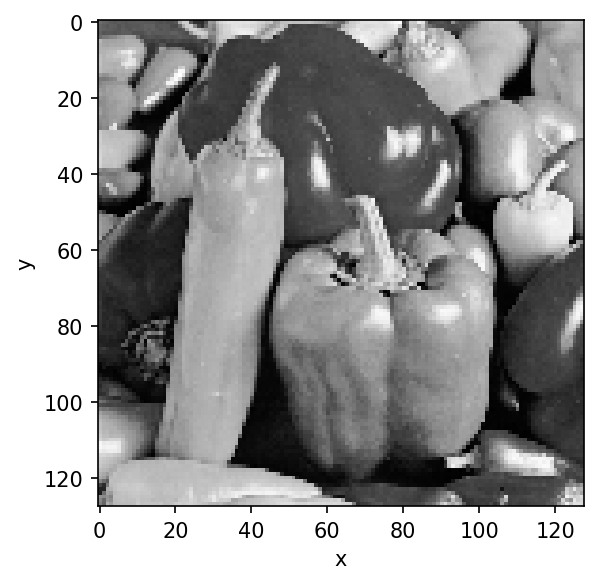

In [3]:
plt.figure(tight_layout=True, dpi=150)
plt.imshow(obj[0], cmap='gray', interpolation='none')
plt.xlabel('x')
plt.ylabel('y')

## Sinogram simulation

TomoPy can simulate parallel-projection through a grid if given a list of angles.

In [4]:
# provide angles in degrees but recieve radians
ang = tomopy.angles(nang=120, ang1=0, ang2=180)
print(ang)

[0.         0.02639994 0.05279988 0.07919981 0.10559975 0.13199969
 0.15839963 0.18479957 0.21119951 0.23759944 0.26399938 0.29039932
 0.31679926 0.3431992  0.36959914 0.39599907 0.42239901 0.44879895
 0.47519889 0.50159883 0.52799877 0.5543987  0.58079864 0.60719858
 0.63359852 0.65999846 0.68639839 0.71279833 0.73919827 0.76559821
 0.79199815 0.81839809 0.84479802 0.87119796 0.8975979  0.92399784
 0.95039778 0.97679772 1.00319765 1.02959759 1.05599753 1.08239747
 1.10879741 1.13519735 1.16159728 1.18799722 1.21439716 1.2407971
 1.26719704 1.29359698 1.31999691 1.34639685 1.37279679 1.39919673
 1.42559667 1.4519966  1.47839654 1.50479648 1.53119642 1.55759636
 1.5839963  1.61039623 1.63679617 1.66319611 1.68959605 1.71599599
 1.74239593 1.76879586 1.7951958  1.82159574 1.84799568 1.87439562
 1.90079556 1.92719549 1.95359543 1.97999537 2.00639531 2.03279525
 2.05919518 2.08559512 2.11199506 2.138395   2.16479494 2.19119488
 2.21759481 2.24399475 2.27039469 2.29679463 2.32319457 2.34959

In [5]:
prj = tomopy.project(obj, ang, pad=True)

In [6]:
print(prj.shape)
# Note that the result is padded by default

(120, 1, 184)


In [7]:
print(prj.dtype)
# Note that the result a floating-point number instead of integer photon counts

float32


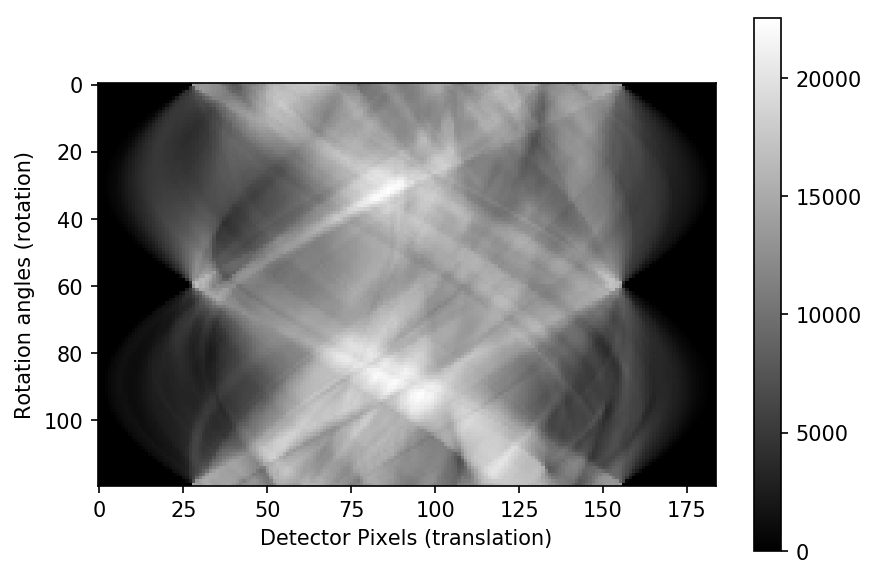

In [8]:
plt.figure(tight_layout=True, dpi=150)
plt.imshow(prj[:, 0, :], cmap='gray', interpolation='none')
plt.xlabel('Detector Pixels (translation)')
plt.ylabel('Rotation angles (rotation)')
plt.colorbar()
plt.show()

### Poisson Noise

In [9]:
prj_poisson = tomopy.add_poisson(prj / 100) * 100

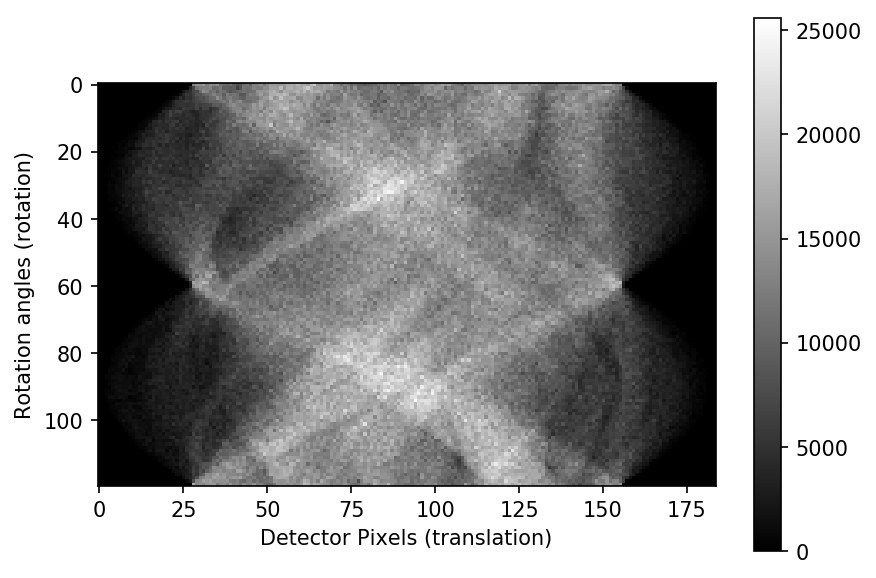

In [10]:
plt.figure(tight_layout=True, dpi=150)
plt.imshow(prj_poisson[:, 0, :], cmap='gray', interpolation='none')
plt.xlabel('Detector Pixels (translation)')
plt.ylabel('Rotation angles (rotation)')
plt.colorbar()
plt.show()

### Rings

In [11]:
def add_rings(tomo, std=0.05):
    """Add rings.
    
    Rings are caused by inconsistent pixel sensitivity across the detector.
    
    The sensitivity of the pixels is modeled as normally distributed with an
    average sensitivity of 1 and a standard deviation given.
    
    
    Parameters
    ----------
    tomo : ndarray
        3D tomographic data.
    std : float
        The standard deviation of the pixel sensitivity

    Returns
    -------
    ndarray
        Tomographic data with zingers added.
    """
    new_tomo = np.copy(tomo)
    sensitivity = np.random.normal(
        loc=1, scale=std,
        size=(1, new_tomo.shape[1], new_tomo.shape[2])
    )
    new_tomo = new_tomo * sensitivity
    return new_tomo

In [12]:
prj_rings = add_rings(prj)

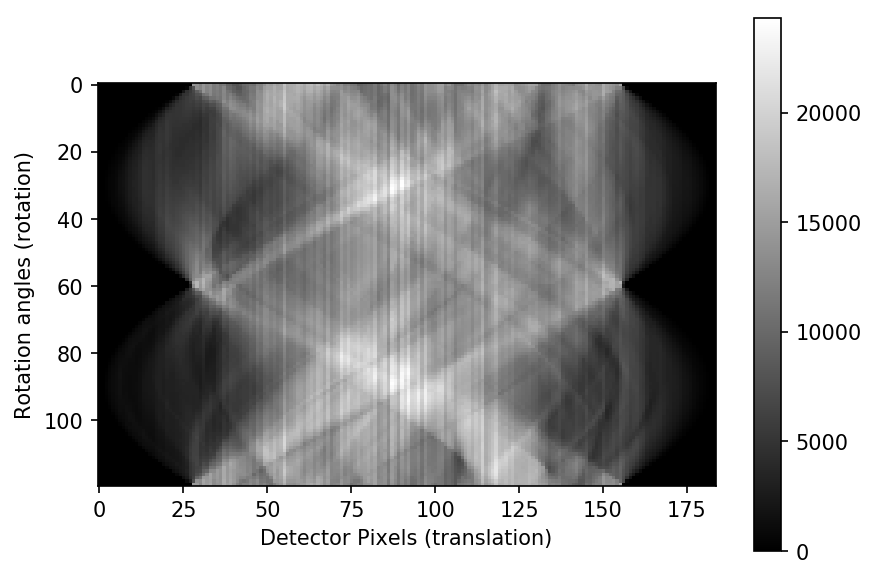

In [13]:
plt.figure(tight_layout=True, dpi=150)
plt.imshow(prj_rings[:, 0, :], cmap='gray', interpolation='none')
plt.xlabel('Detector Pixels (translation)')
plt.ylabel('Rotation angles (rotation)')
plt.colorbar()
plt.show()

### Zingers

In [14]:
def add_zingers(tomo, f=0.01, sat=2**16):
    """Add zingers.
    
    Zingers are caused by stray X-rays hitting the detector and causing pixels
    to saturate.
    
    The zingers are uniformly distributed across the data set with the given
    frequency.
    
    Parameters
    ----------
    tomo : ndarray
        3D tomographic data.
    f : float
        The fraction of measurements that are zingers.
    sat : float
        The pixel saturation value.

    Returns
    -------
    ndarray
        Tomographic data with zingers added.
    """
    zingers = np.random.uniform(0, 1, tomo.shape)
    zingers = zingers <= f  # five percent of measurements are zingers
    new_tomo = np.copy(tomo)
    new_tomo[zingers] = sat
    return new_tomo

In [15]:
prj_zingers = add_zingers(prj, f=0.01, sat=2**13)

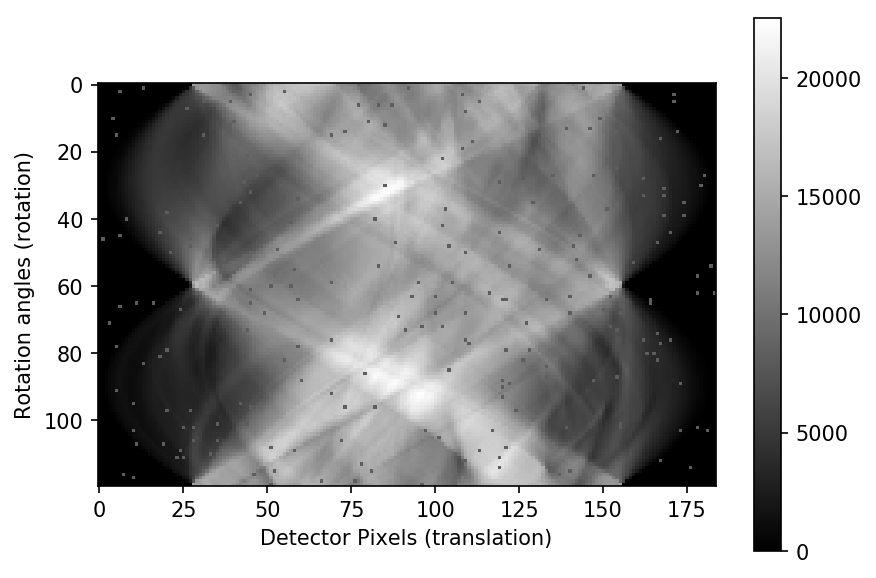

In [16]:
plt.figure(tight_layout=True, dpi=150)
plt.imshow(prj_zingers[:, 0, :], cmap='gray', interpolation='none')
plt.xlabel('Detector Pixels (translation)')
plt.ylabel('Rotation angles (rotation)')
plt.colorbar()
plt.show()

### Illumination drift

In [17]:
def add_drift(tomo, amp=0.2, period=50, mean=1):
    """Add illumination drift.
    
    Illumination drift is caused by the beam instability as the object rotates.
    
    This drift is modeled using a sinusoid. Which alters the illumination
    along the rotation dimension. The vertical dimension is constant.
    
    Parameters
    ----------
    tomo : ndarray
        3D tomographic data.
    amp : float
        The amplitude of the drift.
    period : float
        The period of the drift.

    Returns
    -------
    ndarray
        Tomographic data with zingers added.
    """
    new_tomo = np.copy(tomo)
    x = np.arange(tomo.shape[0])
    drift = amp * np.sin(2 * np.pi / period * x) + mean
    drift = drift + np.linspace(0, 1, len(x))
    drift = drift[:, np.newaxis, np.newaxis]
#     return drift + tomo * 0
    return drift * tomo

In [18]:
prj_drift = add_drift(prj, amp=0.5)

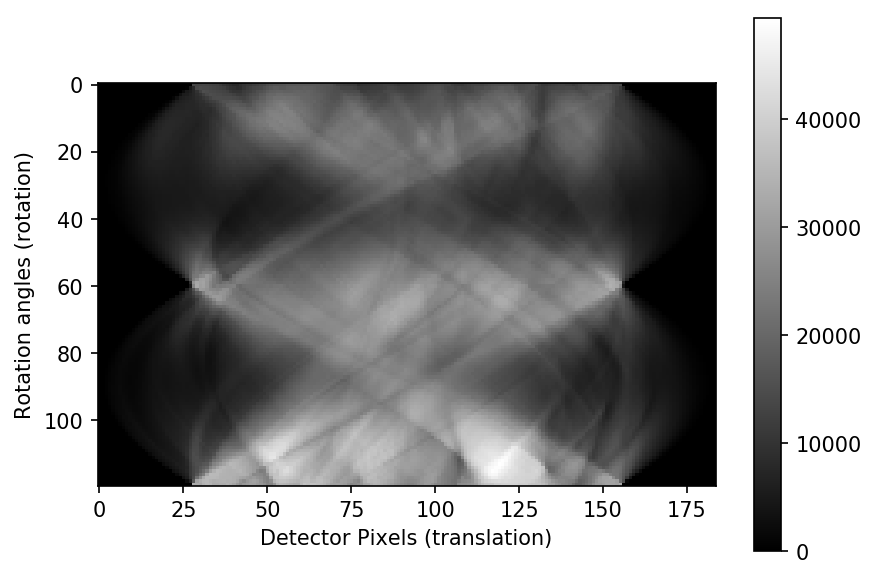

In [19]:
plt.figure(tight_layout=True, dpi=150)
plt.imshow(prj_drift[:, 0, :], cmap='gray', interpolation='none')
plt.xlabel('Detector Pixels (translation)')
plt.ylabel('Rotation angles (rotation)')
plt.colorbar()
plt.show()

### Off-center

In [20]:
prj_center = tomopy.project(obj, ang, pad=True, center=100)
print(prj.shape)
# Note that the result is padded by default

(120, 1, 184)


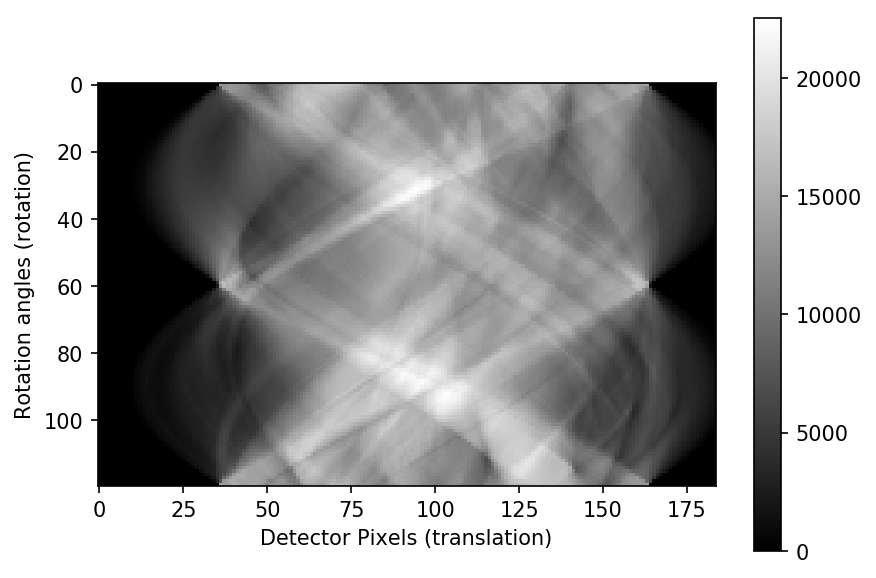

In [21]:
plt.figure(tight_layout=True, dpi=150)
plt.imshow(prj_center[:, 0, :], cmap='gray', interpolation='none')
plt.xlabel('Detector Pixels (translation)')
plt.ylabel('Rotation angles (rotation)')
plt.colorbar()
plt.show()

## Combine data sets and save to file

In [22]:
labels = ['ideal', 'poisson', 'zingers', 'rings', 'illumination drift', 'off-center']
prj_all = np.concatenate([prj, prj_poisson, prj_zingers, prj_rings, prj_drift, prj_center], axis=1)

In [25]:
def write_dxfile(fname, data, ang, data_white=None, data_dark=None, sample_description=''):
    """Store simulated data in data-exchange compliant format."""
    import dxfile.dxtomo as dx
    import os

    experimenter_name="Daniel Ching"
    experimenter_affiliation="Argonne National Laboratory" 
    experimenter_email="dching@anl.gov"
    instrument_comment="TomoPy Simlated Data"
    
    theta = ang / np.pi * 180
    
    if data_white is None:
        data_white = np.ones_like(data[0:1, ...])
    if data_dark is None:
        data_dark = np.zeros_like(data[0:1, ...])
    
    if (fname != None):
        if os.path.isfile(fname):
            print("Data Exchange file already exists: ", fname)
        else:
            # Create new folder.
            dirPath = os.path.dirname(fname)
            if not os.path.exists(dirPath):
                os.makedirs(dirPath)

            # Open DataExchange file
            f = dx.File(fname, mode='w')
            
            # Write the Data Exchange HDF5 file.
            f.add_entry(dx.Entry.experimenter(name={'value':experimenter_name}))
            f.add_entry(dx.Entry.experimenter(affiliation={'value':experimenter_affiliation}))
            f.add_entry(dx.Entry.experimenter(email={'value':experimenter_email}))
            f.add_entry(dx.Entry.instrument(comment={'value': instrument_comment}))
            f.add_entry(dx.Entry.sample( description={'value':sample_description}))    

            f.add_entry(dx.Entry.data(data={'value': data, 'units':'counts'}))
            f.add_entry(dx.Entry.data(data_white={'value': data_white, 'units':'counts'}))
            f.add_entry(dx.Entry.data(data_dark={'value': data_dark, 'units':'counts'}))
            f.add_entry(dx.Entry.data(theta={'value': theta, 'units':'degrees'}))

            f.close()
    else:
        raise ValueError("file name cannot be None")

In [26]:
write_dxfile('data/data-simulated.h5', prj_all, ang,
            sample_description="Simulated data with various distortions.")

In [ ]:
## Reconstruct

In [ ]:
recon = tomopy.recon(tomo=prj_all, theta=ang, algorithm='gridrec')

In [ ]:
for z, label in zip(recon, labels):
    plt.figure(dpi=150)
    plt.title(label)
    plt.imshow(z)